# Проект 5: "Выбираем автомобиль правильно"

<img width="100%" src="https://lh3.googleusercontent.com/proxy/3MrMTf65yLXZPXz_RdNKqJ9_TeHOGAWqGdiVIDvVe-IFS7tso7_QLjweR6rTo-i3uyPOwdKSsFJFwu6yzUwGAcSyrswxOGMlax09bHNb3MKDkzEG5iEWIBwzoCD-FnkQ8nw"/>

## Цель работы
Спрогнозировать стоимость автомобиля исходя из его характеристик, размещенных в открытом доступе на сайте <a href="https://auto.ru/">auto.ru</a>

## Исходные данные
1. Тестовый дата-сет предоставлен
2. Тренировочный дата-сет необходимо самостоятельно получить с использованием API `auto.tu`

## Подготовка

1. Анализ и предобработка тестового дата-сета проведен в ноутбуке `prepare_test`. В нем тестовый дата-сет очищен от лишних и дублирующихся данных, формат остальных данных приведен к более удобному для дальнейшей обработки виду. Результатом выполнения этого ноутбука является файл очищенного тестовго дата-сета `test_clean.csv`

2. Выгрузка и парсинг объявлений с сайта auto.ru проведен в ноутбуке `collect_data`. В нем описан разбор формата ответов сайта, приведены методы выгрузки и парсинга сообщений. Результат исполнения ноутбука - файл тренировочного дата-сета `train.csv`

Данные ноутбуки созданы с единственной целью - разбить работу на блоки по смыслу, чтобы каждый из них было проще анализировать.

Для начала проведем подготовительные мероприятия:

In [1]:
import re
import sys
import numpy as np
import pandas as pd
import pandas.api.types as at
from tqdm import tqdm
from datetime import timedelta, datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import ast
import json
import gc

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (20, 7)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 73
TEST_SIZE = 0.25;

# определим функицю метрики, по которой будет оцениваться качество модели
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

Python       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
Numpy        : 1.19.2


In [2]:
# TODO - replace in kaggle
DIR_TRAIN  = './'
DIR_TEST   = './'

## 1. Данные

In [3]:
df_train = pd.read_csv(DIR_TRAIN + 'train.csv') # датасет для обучения модели
df_test = pd.read_csv(DIR_TEST + 'test_clean.csv')

display(df_train.head(2))
display(df_test.head(2))

,body_type,brand,color,complectation,description,engine_vol,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,num_owners,ownership,docs,drive,steering,price
0,ALLROAD_5_DOORS,SKODA,C49648,"{'id': '21837046', 'name': 'Active (2020-2021)...",В стоимость автомобиля включено дополнительное...,1.4,150,"{'engine-proof': True, 'asr': True, 'glonass':...",GASOLINE,0,2017,KAROQ,5,NaN,2021,AUTOMATIC,0,0,NaN,0,FORWARD_CONTROL,0,1915400
1,LIFTBACK,SKODA,200204,"{'id': '2436032', 'name': 'Elegance', 'availab...",Причина продажи — куплен новый автомобиль \nКо...,1.8,152,"{'cruise-control': True, 'asr': True, 'tinted-...",GASOLINE,179000,2008,SUPERB,5,NaN,2012,AUTOMATIC,0,2,NaN,0,FORWARD_CONTROL,0,880000


,body_type,brand,color,complectation,description,engine_vol,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,num_owners,ownership,docs,drive,steering
0,LIFTBACK,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2,105,"{""engine-proof"":true,""tinted-glass"":true,""airb...",GASOLINE,74000,2013,OCTAVIA,5,1603226273,2014,ROBOT,0,3,NaN,0,FORWARD_CONTROL,0
1,LIFTBACK,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6,110,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",GASOLINE,60563,2017,OCTAVIA,5,1603226277,2017,MECHANICAL,0,1,NaN,0,FORWARD_CONTROL,0


### 1.1. price

`price` - это целевая переменная. Крайне важно, чтобы в ней не было пропусков и невализных значений. Проверим.

Всего пропусков в столбце "price": 0
Всего нулевых значений в столбце "price": 0


<AxesSubplot:>

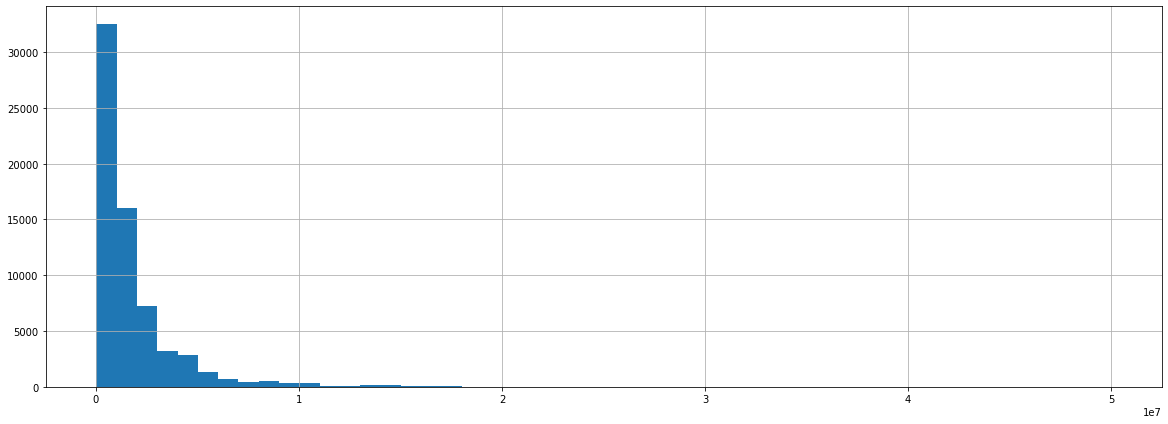

In [4]:
print('Всего пропусков в столбце "price":', df_train.price.isna().sum())
print('Всего нулевых значений в столбце "price":', df_train.price.isnull().sum())
df_train.price.hist(bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fee0f8fdbb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fee0f90c250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fee0f8fd760>],
 'medians': [<matplotlib.lines.Line2D at 0x7fee0f90c970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fee0f90cd30>],
 'means': []}

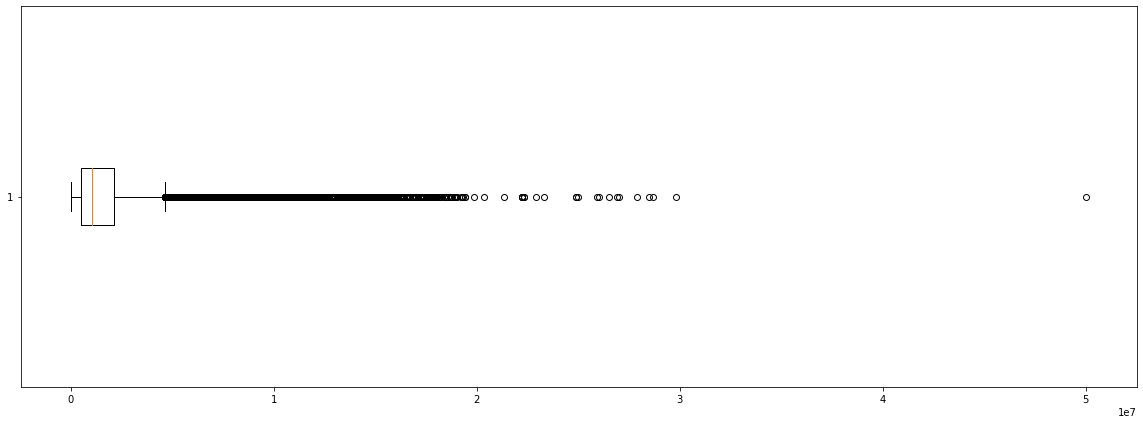

In [5]:
plt.boxplot(df_train.price, vert=False)

Данные распределены экспоненциально, что ожидаемо, есть выбросы, необходимо проверить их на адекватность

In [6]:
most_expensive = df_train.price.sort_values(ascending=False).head(20).index
df_train.loc[most_expensive].sample(5)

,body_type,brand,color,complectation,description,engine_vol,engine_power,equipment,fuel_type,mileage,model_date,model_name,doors_num,parsing_unixtime,production_date,transmission,vendor,num_owners,ownership,docs,drive,steering,price
63067,MINIVAN,MERCEDES,040001,{'id': '0'},Zart 89 Royal\nПриобрести данный автомобиль мо...,2.1,190,"{'navigation': True, 'front-seats-heat-vent': ...",DIESEL,1,2014,V_KLASSE,5,NaN,2020,AUTOMATIC,0,1,NaN,0,ALL_WHEEL_DRIVE,0,28700000
65500,COUPE,MERCEDES,97948F,"{'id': '2534065', 'name': 'SLR McLaren', 'avai...","Кузов выполнен полностью из карбона, единствен...",5.4,626,"{'cruise-control': True, 'asr': True, 'esp': T...",GASOLINE,15000,2003,SLR_KLASSE,2,NaN,2004,AUTOMATIC,0,4,NaN,1,REAR_DRIVE,0,22900000
62198,MINIVAN,MERCEDES,040001,"{'id': '21363629', 'name': 'V250 d Avantgarde ...",Zart 91 Radiance\n\nПриобрести данный автомоби...,2.1,190,"{'esp': True, 'usb': True, 'multi-wheel': True...",DIESEL,1,2014,V_KLASSE,5,NaN,2020,AUTOMATIC,0,1,NaN,0,ALL_WHEEL_DRIVE,0,24900000
62823,COUPE,MERCEDES,040001,{'id': '0'},Продается SLR из частной коллекции.,5.4,626,{},GASOLINE,28600,2003,SLR_KLASSE,2,NaN,2005,AUTOMATIC,0,4,NaN,0,REAR_DRIVE,0,50000000
62271,ALLROAD_5_DOORS,MERCEDES,0000CC,"{'id': '21217612', 'name': 'AMG G 63', 'availa...",Аэродинамический обвес BRABUS WIDESTAR\nВставк...,4.0,585,"{'cruise-control': True, 'tinted-glass': True,...",GASOLINE,7711,2018,G_KLASSE_AMG,5,NaN,2020,AUTOMATIC,0,1,NaN,0,ALL_WHEEL_DRIVE,0,28500000


В общем-то нет ничего необычного, дорогие машины дорого стоят. 

Единственное, что следует сделать с целевой переменной - логарифмировать. а заодно сразу выделить отдельно от остального дата-сета

In [7]:
y = np.log(1 + df_train.price) # dummy fix for zero values (safety first!!!)
df_train.drop(columns='price', inplace=True)

### 1.2. color
Приведем обозначение цвета к единой номерклотуре. В тренировочном дата-сете цвет в формате RGB, в тестовом - в виде русских наименований цвета. Поскольку столбец категоральный и будет или дропнут или заменен dummy-переменными, будем использовать русские цвета, т.к. они проще в восприятии.

In [8]:
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
df_train['color'] = df_train['color'].map(dict_color)

### 1.3. parsing_unixtime

Столбец характеризует дату/время обработки объявления с сайта. В тестовом дата-сете он указан, а в тренировочном пропущен, т.к. я забыл его добавить на момент выгрузки данных. Эти данные для моделирования бесполезны, но нужны для введения поправки на валютные курсы, инфляцию и т.п. на стадии формирования сабмишна. поэтому из тестового набора их надо отложить, в из тренировочного - врять время создания файла `train.csv`.

In [9]:
# translate from unix time in seconds to pandas Timestamp
df_test.parsing_unixtime = pd.to_datetime(df_test.parsing_unixtime, unit='s')

In [10]:
# copy to temporary variable
time_test = df_test.parsing_unixtime.copy()
(time_test.min(), time_test.max())

(Timestamp('2020-10-19 11:35:06'), Timestamp('2020-10-26 11:04:24'))

In [11]:
# This is how to get this time in ideal conditions
# time_train = pd.Timestamp(path.getmtime(DIR_TRAIN + 'train.csv'), unit='s')

# This is the most safe way to get it
time_train = pd.Timestamp('2021-07-26 18:40:10.601043463')
df_train.parsing_unixtime = time_train

Для упрощения дальнейшей обработки необходимо объединить тестовый и тренировочный дата-сеты в один. 

In [12]:
df_train['train'] = 1
df_test['train'] = 0
df = pd.concat([df_train, df_test], ignore_index=True)

In [13]:
time_all = df.parsing_unixtime.copy()

### 1.4. complectation

Столбец `complectation` содержит описание комплектации. В них надо хорошо разбираться, чтобы использовать. 
Оставим это вне рамок текущей версии ноутбука.

In [14]:
df.drop(columns='complectation', inplace=True)

### 1.5. description

Столбцу `description` требуется семантический анализ. Отложим его пока в сторону.

In [15]:
description = df.description.copy()
df.drop(columns='description', inplace=True)

### 1.6. equipment

Столбец `equipment` строковых, но очевидно, содержит в себе json, которй описывает комплектации автомобиля. Для начала необходимо его распарсить, а потом обработать. На первом этапе для моделирования возьмем просто количество ключей в json-объекте - по идее, чем богаче комплектация, тем опций должно быть больше, тем дороже должна быть машина. В идеале - надо делать некий рейтинг опций по дороговизне (напрмиер, климат-контроль дороже кондиционера, но вместе они не устанавливаются), но для учебного проекта хватит и количества.

In [16]:
# try to parse string as string representation of Python's dict
def parse_str_dict(s):
    try:
        obj = ast.literal_eval(s)
        return len(obj.keys())
    except:
        return -1
    
    
def parse_json(s):
    try:
        obj = json.loads(s, strict=False)
        return len(obj.keys())
    except:
        return -1

    
def pasre_equipment(s):
    # if empty, NaN or empty object - just return 0
    if pd.isna(s) or s == '{}':
        return 0
    
    # then - try to parse as string representation of Python's dict
    res = parse_str_dict(s)
    # in case of failure - try to parse as JSON
    return res if res > -1 else parse_json(s)

# parse equipment
equipment = df.equipment.apply(pasre_equipment)
# find all invalid values (neither str. rep. of dict nor JSON)
wrong = equipment[equipment == -1].index
# and print them
df.equipment.loc[wrong]

Series([], Name: equipment, dtype: object)

Отлично, ошибок не осталось, можно заменить столбец `equipment` в дата-сете

In [17]:
df.equipment = equipment

### 1.7. ownership

столбец `ownership` описывает время владения в дробных годах (см ноутбук `prepare_test`). В столбце многопропусков, т.к. в тренировочной выборке он вообще не заполнялся, да и в тестовой выборке пропуски присутствовали. Исправим это самым простым путем - вычтем из `parsing_time` год выпуска `production_date`. за неимением других данных - это довольно точная оценка

In [18]:
def fill_ownership(row):
    if not pd.isna(row.ownership):
        return row.ownership
    
    diff = (row.parsing_unixtime - pd.to_datetime(row.production_date, format='%Y')).days / 365.0
    return diff

df.ownership = df.apply(fill_ownership, axis=1)

### 1.8. пропуски

взглянем на столбцы, в которых есть пропуски или `NaN`

In [19]:
df.isna().sum()

body_type           0
brand               0
color               0
engine_vol          0
engine_power        0
equipment           0
fuel_type           0
mileage             0
model_date          0
model_name          0
doors_num           0
parsing_unixtime    0
production_date     0
transmission        0
vendor              0
num_owners          0
ownership           0
docs                0
drive               0
steering            0
train               0
dtype: int64

Отлично, таковых нет.

### 1.9. типы данных

Проверим, соответствуют ли типы даныых столбцов дата-сета фактическим данным, которые там содержатся

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100920 entries, 0 to 100919
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   body_type         100920 non-null  object        
 1   brand             100920 non-null  object        
 2   color             100920 non-null  object        
 3   engine_vol        100920 non-null  float64       
 4   engine_power      100920 non-null  int64         
 5   equipment         100920 non-null  int64         
 6   fuel_type         100920 non-null  object        
 7   mileage           100920 non-null  int64         
 8   model_date        100920 non-null  int64         
 9   model_name        100920 non-null  object        
 10  doors_num         100920 non-null  int64         
 11  parsing_unixtime  100920 non-null  datetime64[ns]
 12  production_date   100920 non-null  int64         
 13  transmission      100920 non-null  object        
 14  vend

Да, расхождений нет.

Теперь наконец избавимся от столбца `parsing_unixtime`

In [21]:
df.drop(columns='parsing_unixtime', inplace=True)

## 2. Немного EDA

Поскольку большая часть данных была обработана и очищена на ранних этапах, нет смысла в глубоком EDA. Просто можно для порядка оценить наличие мультиколлинеарности в данных, чтобы попытаться уменьшить размерность дата-сета

<AxesSubplot:>

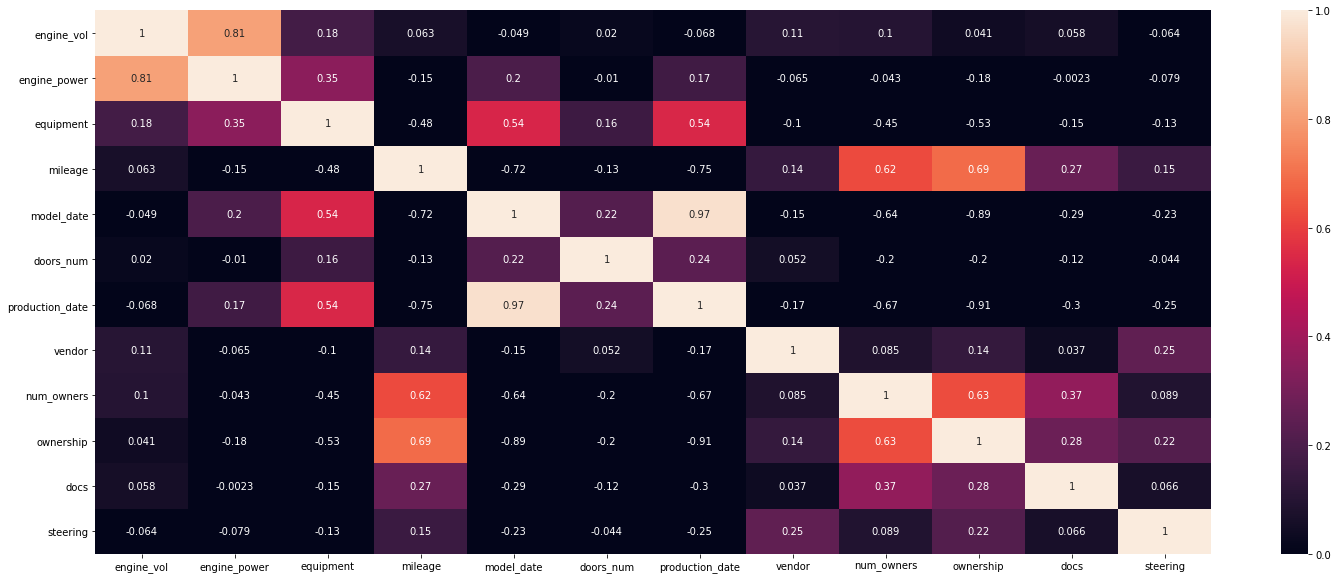

In [22]:
corr = df.drop(columns=['train']).corr()
fig, axes = plt.subplots(figsize=(25,10))
sns.heatmap(corr, ax=axes, vmin=0, vmax=1, annot = True)

Видим наличие сильной положительной корреляции в столбцах `model_date` и `production_date` - почти 1. Избавимся от любого из них на выбор, я предпочту убрать `model_date`.

Следом идут столбцы `engine_power` и `engine_vol` с корреляцией `0.81`, что тоже не удивительно - больше двигатель = больше лошадок. 

Также есть значительная корреляция между столбцами `mileage`, `num_owners` и `ownership`.
Прежде чем принять решение об удалении каких-либо из этих столбцов, проведем тривиальное моделирование.

In [23]:
df.drop(columns='model_date', inplace=True)

## 3. Подготовка данных к моделированию
### 3.1. Числовые признаки

In [24]:
num_columns = ['engine_vol', 'engine_power', 'equipment', 'mileage', 'doors_num', 
               'production_date', 'num_owners', 'ownership']
df[num_columns] = StandardScaler().fit_transform(df[num_columns])
df.head(1)

,body_type,brand,color,engine_vol,engine_power,equipment,fuel_type,mileage,model_name,doors_num,production_date,transmission,vendor,num_owners,ownership,docs,drive,steering,train
0,ALLROAD_5_DOORS,SKODA,бежевый,-0.930499,-0.311996,0.527459,GASOLINE,-1.249535,KAROQ,0.687785,1.248504,AUTOMATIC,0,-1.546509,-1.162752,0,FORWARD_CONTROL,0,1


### 3.2. Категоральные признаки

Псомтрим, какие из категоральных столбцов могут быть преобразованы в число, а какие в dummy-переменные

In [25]:
cat_columns = ['body_type', 'brand', 'color', 'fuel_type', 'model_name', 'transmission', 'drive']
df[cat_columns].nunique()

body_type         26
brand             36
color             16
fuel_type          5
model_name      1127
transmission       4
drive              3
dtype: int64

В dummy-переменные я вижу смысл преобразовать столбцы `fuel_type`, `transmission` и `drive`, отсальные - преобразуем в число по категориям.

In [26]:
cat_columns = ['body_type', 'brand', 'color', 'model_name']
for col in cat_columns:
    df[col] = df[col].astype('category').cat.codes

In [27]:
dum_columns = ['fuel_type', 'transmission', 'drive']
df = pd.get_dummies(df, columns=dum_columns) 

Посмотрим, что же получилось

In [28]:
df.sample(10)

,body_type,brand,color,engine_vol,engine_power,equipment,mileage,model_name,doors_num,production_date,vendor,num_owners,ownership,docs,steering,train,fuel_type_DIESEL,fuel_type_ELECTRO,fuel_type_GASOLINE,fuel_type_HYBRID,fuel_type_LPG,transmission_AUTOMATIC,transmission_MECHANICAL,transmission_ROBOT,transmission_VARIATOR,drive_ALL_WHEEL_DRIVE,drive_FORWARD_CONTROL,drive_REAR_DRIVE
30068,19,20,15,-0.708616,-0.836589,0.287757,0.538825,31,-0.822666,-0.513972,1,1.696479,0.661615,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
28924,1,20,11,-0.264850,-0.311996,-0.031846,-0.546896,314,0.687785,0.163903,1,-0.735762,-0.040242,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
2017,19,0,15,0.955506,0.970341,-0.311499,1.124247,99,-0.822666,-0.649547,0,1.696479,0.801833,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0
33793,4,23,11,0.178916,-0.346969,-1.190407,0.905859,905,0.687785,-1.191848,1,1.696479,1.363088,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
67759,11,29,1,-0.930499,-0.428572,-0.830854,0.447937,693,0.687785,0.163903,0,0.074985,-0.295419,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
61634,1,18,13,-0.042967,-0.311996,0.527459,1.532898,430,0.687785,0.028328,0,0.074985,0.100360,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0
10712,1,4,6,-0.597674,-1.128029,-0.750953,-1.059632,683,0.687785,0.706204,0,-0.735762,-0.601497,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
33113,19,23,1,-0.264850,-0.486860,-0.551201,0.896364,574,-0.822666,-0.785123,1,0.885732,0.942051,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
73778,11,1,15,-0.264850,0.842108,2.245326,-1.201347,70,0.687785,0.977354,0,-0.735762,-0.989497,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
81732,19,21,15,0.844564,1.821347,-1.190407,-0.043654,943,-0.822666,0.706204,0,0.885732,-0.708293,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0


### 3.3. Разделение датасета

In [29]:
X = df[df.train == 1].drop(columns='train') # modeling and validating
X_sub = df[df.train == 0].drop(columns='train') # submission
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
y_test_lin = np.exp(y_test) - 1 # convert from log-scale to linear

## 4. Модели

### 4.1. Тривиальная модель
В качестве собственной baseline-модели возьмем простейший регрессор - `LinearRegression`

In [30]:
def fit_predict(m):    
    m.fit(X_train, y_train)
    return m.predict(X_test)


def run_model(m, run=fit_predict):
    start = pd.Timestamp('now')
    y_pred = run(m)
    y_pred = np.exp(y_pred) - 1 # convert from log-scale to linear
    end = pd.Timestamp('now')
    score = mape(y_test_lin, y_pred)
    exec_time = (end - start).total_seconds()
    print(f'MAPE: {np.round(score * 100, 2)}%, done in {np.round(exec_time, 3)}s')
    gc.collect()

In [31]:
run_model(LinearRegression(n_jobs=-1))

MAPE: 27.38%, done in 0.026s


### 4.2. RandomForestRegressor

Попытка 1: дефолтные параметры

In [32]:
run_model(RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))


MAPE: 12.31%, done in 1.024s


Попытка 2: подбор наилучших параметров

In [33]:
#
# This is how to find meta features for best_rfr
#
# random_grid = {'n_estimators': [100, 250, 500],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [int(x) for x in np.linspace(50, 150, num = 6)],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}
# rfcv = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=RANDOM_SEED), 
#                           param_distributions=random_grid, 
#                           n_iter=100, 
#                           cv=3, 
#                           verbose=2, 
#                           random_state=RANDOM_SEED,
#                           n_jobs=-1)
# run_model(rfcv)
# rfcv.best_params_

best_rfr = RandomForestRegressor(random_state=RANDOM_SEED,
                                 n_estimators=500,
                                 min_samples_split=5,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=130,
                                 bootstrap=False,
                                 n_jobs=-1)

In [33]:
run_model(best_rfr)

MAPE: 12.12%, done in 1.856s


Немного улучшили, двигаемся дальше

### 4.3. CatBoost

In [34]:
def fit_predict_catboost(m):
    m.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          use_best_model=True,
          verbose=False,
          plot=True)    
    m.save_model('catboost_model.model')
    return m.predict(X_test)


cb = CatBoostRegressor(iterations = 1000,
                       cat_features=cat_columns,
                       random_seed = RANDOM_SEED,
                       eval_metric='MAPE',
                       custom_metric=['R2', 'MAE'],
                       silent=True)

run_model(cb, fit_predict_catboost)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAPE: 12.31%, done in 10.478s


12.31% - не лучше лучшего случайного леса, но тоже неплохо. Едем дальше.

### 4.4. Gradient Boosting Regressor

попытка 1: дефолтные параметры:

In [35]:
run_model(GradientBoostingRegressor(random_state=RANDOM_SEED))

MAPE: 18.98%, done in 5.595s


18.98% многовато. Попробуем оптимизировать.

In [31]:
# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4]}

# gbrcv = RandomizedSearchCV(estimator = GradientBoostingRegressor(random_state=RANDOM_SEED), 
#                            param_distributions = random_grid, 
#                            n_iter = 100, 
#                            cv = 3, 
#                            verbose=10, 
#                            random_state=RANDOM_SEED, 
#                            n_jobs = -1)
# run_model(gbrcv)
# gbrcv.best_params_

best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                     n_estimators=400,
                                     min_samples_split=10,
                                     min_samples_leaf=4,
                                     max_features='auto',
                                     max_depth=7)

In [36]:
run_model(best_gbr)

MAPE: 12.03%, done in 50.092s


12.03% Новый рекорд. Еще немного


### 4.5. XGB Regressor

In [37]:
run_model(xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                           learning_rate=0.05, max_depth=12, alpha=1,
                           n_estimators=1000))

MAPE: 11.4%, done in 19.36s


11.4%!!! Время тяжелой артиллерии

## 5. Бэггинг

### 5.1. Со случайным лесом

In [34]:
run_model(BaggingRegressor(best_rfr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED))

MAPE: 12.57%, done in 9.494s


12.57% - хуже чем без бустинга

### 5.2. С градиентным бустингом

In [35]:
run_model(BaggingRegressor(best_gbr, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED))

MAPE: 12.08%, done in 32.833s


12.08% с бустингом по сравнению с 12.03% без. А нам точно нужен бустинг?


## 6. Стеккинг. Ансамбли моделей

In [36]:
estimators = [('rfr', best_rfr),
              ('gbr', best_gbr),
              ('xgb', xgb.XGBRegressor(objective='reg:squarederror', 
                                       colsample_bytree=0.5,
                                       learning_rate=0.05, 
                                       max_depth=12, 
                                       alpha=1,
                                       n_estimators=1000))]

In [37]:
run_model(StackingRegressor(estimators=estimators, final_estimator=LinearRegression(n_jobs=8), n_jobs=8))

MAPE: 11.33%, done in 197.992s


In [38]:
meta_estimator = CatBoostRegressor(iterations = 5000,
                                   random_seed = RANDOM_SEED,
                                   eval_metric='MAPE',
#                                    custom_metric=['R2', 'MAE'],
                                   silent=True,
                                   learning_rate=0.13,
                                   depth=12,
                                   l2_leaf_reg=8,
                                   random_strength=0.3)

run_model(StackingRegressor(estimators=estimators, final_estimator=meta_estimator, n_jobs=8))

MAPE: 12.17%, done in 342.01s


Пока что лучшей моделью c резуьтатом `MAPE 11.33%` является стекинг из линейной регрессии над корзиной из 3 моделей: `RandomForestREgressor`, `GradientBoostingRegressor`, `XGBRegressor`

## 7. Submission

In [39]:
final_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(n_jobs=8), n_jobs=8)

final_model.fit(X, y)

predict_submission = np.round(np.exp(final_model.predict(X_sub)) - 1)
predict_submission 

array([ 763930., 1076864., 1133647., ...,  267264., 1418517., 1678545.])

Делаем поправку на курс доллара. В октябре 2020 (на момент выргузки тестового дата-сета) средний курс доллара составлял `77.65` рублей, согласно данным с сайта <a href="https://cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.10.2020&UniDbQuery.To=26.10.2020">ЦБ РФ</a>, а на момент создания тренировочного дата-сета - `73.98`. Также учтем удорожание автомобилей из-за внутренних экономических факторов. Беглый анализ показал, что автомобили в первой половине 2021 года подорожали как минимум на четверть по сравенеию с концом 2020 года.

А еще неплохо для улучшения оценки округлять цену до тысяч.

In [52]:
df_test_orig = pd.read_csv('test.csv')
koef = 77.65 / (73.98 * 1.25)
df_test_orig['price'] = 1000.0 * np.round(predict_submission * koef / 1000.0)
sample_submission = df_test_orig[['sell_id', 'price']]
sample_submission.sample(10)

,sell_id,price
33253,1101361417,1266000.0
1257,1100588382,713000.0
16160,1101228989,1699000.0
29052,1091054792,1635000.0
30088,1100333042,525000.0
28437,1099100847,252000.0
13499,1101315449,439000.0
21134,1101104445,1459000.0
13642,1101297143,268000.0
3299,1101130674,646000.0


In [53]:
today = pd.Timestamp('now').strftime('%Y%m%d')
sample_submission.to_csv(f'submission_{today}.csv', index=False)

Score данного сабмишна на kaggle: **`21.68184`**

# Выводы
Что еще можно сделать, чтобы улучшить результат:

* попытаться выгрузить больше данных с сайта `auto.ru` (догружать в течение некоторого времени или делать больше запросов с более узкими фильтрами)
* **Feature ingeneering** - посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Попробовать другие алгоритмы и библиотеки ML
* Использовать другие комбинации моделей для **стеккинга**

Результат, несомненно, можно улучить еще, но целью работы было показать, как бэггинг и стекинг нескольких улучшают предсказательную силу каждой отдельно взятой. Собственно, это в результате работы и было показано.

Baseline побит.
В ходе работы были закреплены навыки:
* оптимизации гиперпараметров моделей
* работы с ансамблями моделей
* работы с произвольным API на примере `auto.ru`
Цели работы, я считаю, достигнуты.